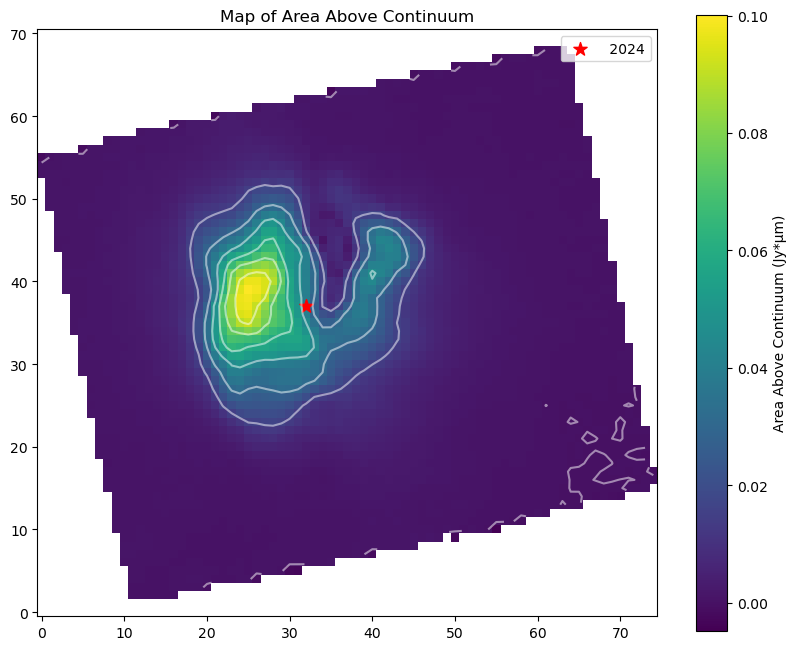

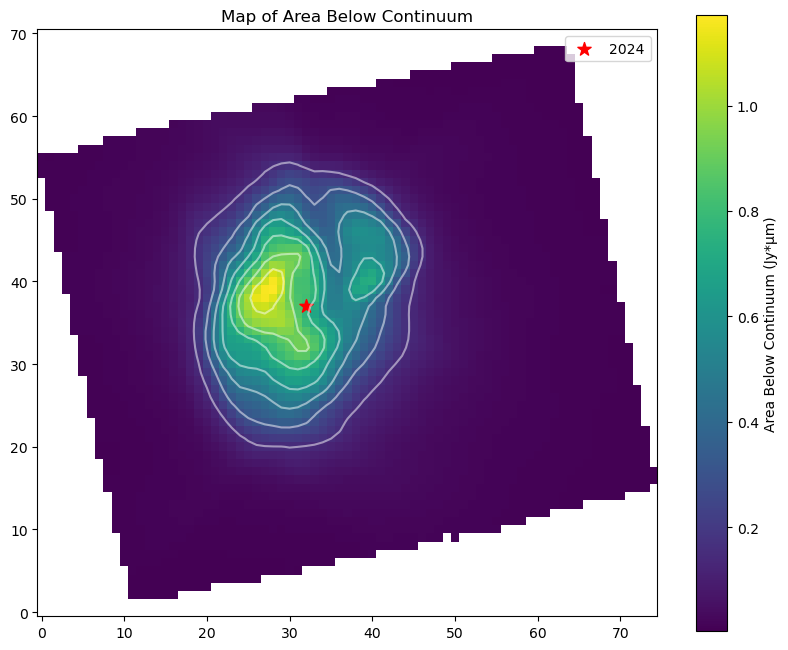

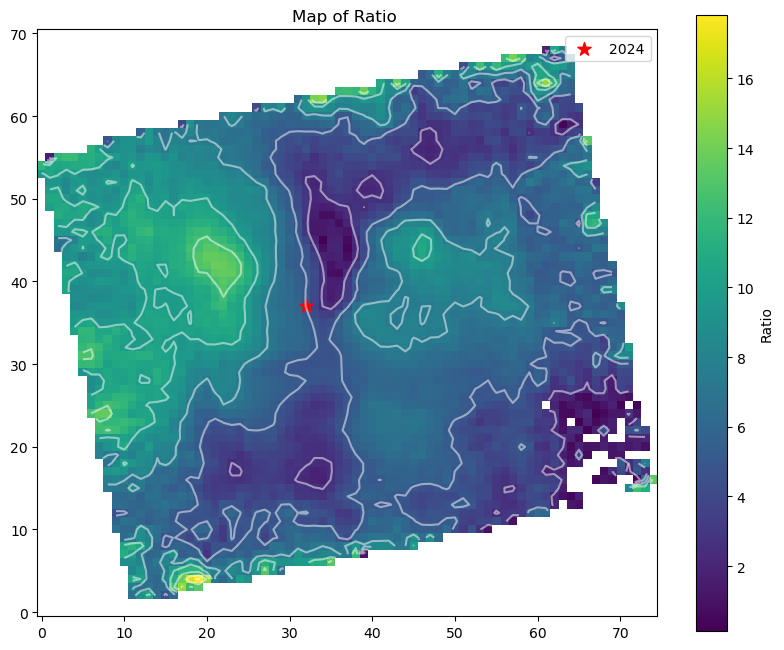

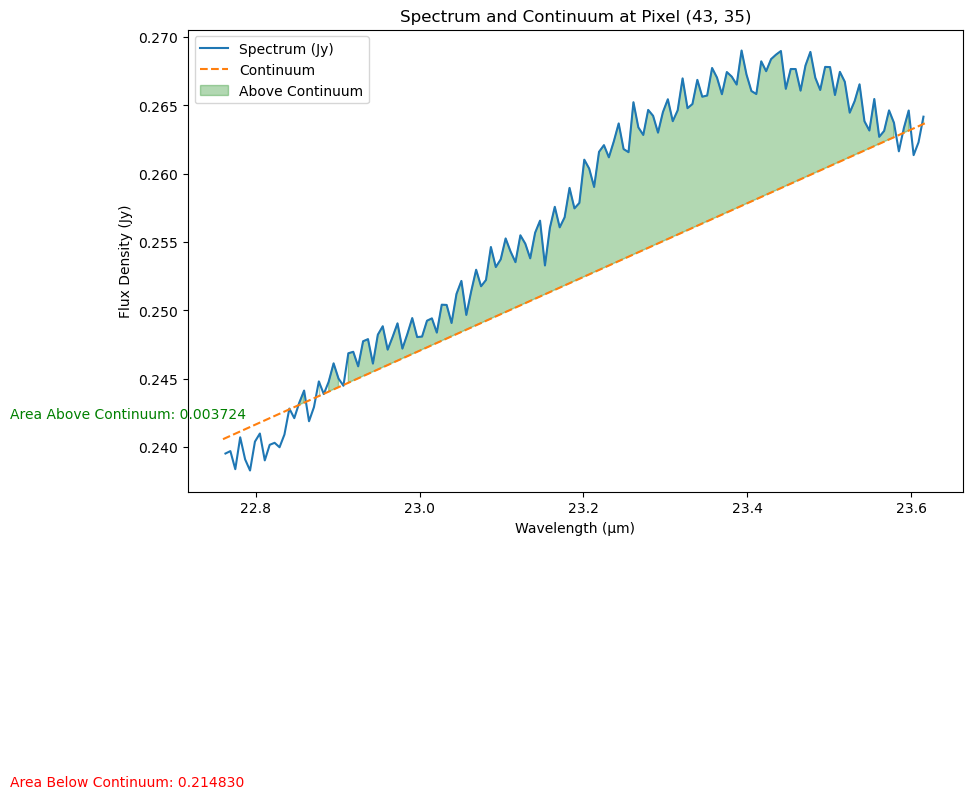

Calculated Area Above Continuum: 0.003724049372590993
Stored Area Above Continuum: 0.006633
Calculated Area Below Continuum: 0.21482977701512318
Stored Area Below Continuum: 0.415176
stored ratio_map: 1.597637


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpdaf.obj import Cube
import astropy.units as u
import plotly.express as px
import warnings
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

# Ignore warnings
warnings.filterwarnings('ignore', category=astropy.wcs.FITSFixedWarning)
warnings.filterwarnings('ignore', category=UserWarning, message="Warning: converting a masked element to nan.")

ra_deg = 258.4353666666666 
dec_deg = -37.10326666666667  

cube_path = '/Users/mary/Fits image of JWST/ngc6302_ch4-medium_s3d.fits'
obj1 = Cube(cube_path)
wcs = obj1.wcs.wcs  
skycoord = SkyCoord(ra=ra_deg*u.degree, dec=dec_deg*u.degree, frame='icrs')
pixcoords = wcs.world_to_pixel(skycoord)
pixel_x, pixel_y = int(pixcoords[0]), int(pixcoords[1])
central_star_coords = (pixel_x, pixel_y)
pixel_size = obj1.wcs.get_step(unit=u.arcsec)[0]
solid_angle = (pixel_size * u.arcsec).to(u.rad)**2
#The negative area above continuum line of these pixel with change the range of continuum became posative
specific_pixels = [(42, 36), (42, 35), (44, 36),(44,35),(43,35),(43,36),(47,35), (25,61),(45, 36), (45, 35), (46, 36), (46, 35), (46, 34), (47, 34)]

def process_pixel_data(cube, solid_angle, central_star_coords):
    wavelength = cube.wave.coord()
    mask_range = (wavelength >= 22.4) & (wavelength <= 24.05)
    filtered_wavelengths = wavelength[mask_range]

    area_above_continuum_map = np.zeros((cube.shape[1], cube.shape[2]))
    area_below_continuum_map = np.zeros((cube.shape[1], cube.shape[2]))
    ratio_map = np.zeros((cube.shape[1], cube.shape[2]))

    negative_area_pixels = []
    for x in range(cube.shape[1]):
        for y in range(cube.shape[2]):
            pixel_flux_density = cube.data[:, x, y] * solid_angle.value * 1e6
            filtered_pixel_flux_density = pixel_flux_density[mask_range]

            if (x, y) in specific_pixels:
                mask_start = (filtered_wavelengths >= 22.66) & (filtered_wavelengths <= 22.86)
                mask_end = (filtered_wavelengths >= 23.52) & (filtered_wavelengths <= 23.72)
                wavelengths = [22.76, 23.62]
            else:
                mask_start = (filtered_wavelengths >= 22.35) & (filtered_wavelengths <= 22.45)
                mask_end = (filtered_wavelengths >= 24) & (filtered_wavelengths <= 24.1)
                wavelengths = [22.4, 24.05]

            continuum_start = np.mean(filtered_pixel_flux_density[mask_start])
            continuum_end = np.mean(filtered_pixel_flux_density[mask_end])
            average_intensities = [continuum_start, continuum_end]
            pixel_continuum_line = np.interp(filtered_wavelengths, wavelengths, average_intensities)

            total_area = np.trapz(filtered_pixel_flux_density, filtered_wavelengths)
            area_below_continuum = np.trapz(pixel_continuum_line, filtered_wavelengths)
            area_above_continuum = total_area - area_below_continuum

            area_above_continuum_map[x, y] = area_above_continuum
            area_below_continuum_map[x, y] = area_below_continuum

            # Calculate the ratio
            if area_below_continuum != 0  and area_above_continuum > 0 :
                ratio_map[x, y] = area_above_continuum / area_below_continuum
            else:
                ratio_map[x, y] = np.nan
                
            if area_above_continuum < 0 :
                ratio_map[x, y] = np.nan  

    ratio_map *= 100

    np.savetxt('23.71area_above_continuum.txt', area_above_continuum_map, fmt='%.6f')
    np.savetxt('23.71area_below_continuum.txt', area_below_continuum_map, fmt='%.6f')
    np.savetxt('23.71ratio_map.txt', ratio_map, fmt='%.6f')

    plt.figure(figsize=(10, 8))
    plt.imshow(area_above_continuum_map, cmap='viridis', origin='lower')
    plt.colorbar(label='Area Above Continuum (Jy*µm)')
    plt.title('Map of Area Above Continuum')
    plt.contour(area_above_continuum_map, colors='white', alpha=0.5)
    plt.scatter(*central_star_coords, color='red', marker='*', s=100, label=' 2024')
    plt.legend()
    plt.savefig('23.71area_above_continuum_map.png', dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.imshow(area_below_continuum_map, cmap='viridis', origin='lower')
    plt.colorbar(label='Area Below Continuum (Jy*µm)')
    plt.title('Map of Area Below Continuum')
    plt.contour(area_below_continuum_map, colors='white', alpha=0.5)
    plt.scatter(*central_star_coords, color='red', marker='*', s=100, label='2024')
    plt.legend()
    plt.savefig('23.71area_below_continuum_map.png', dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.imshow(ratio_map, cmap='viridis', origin='lower')
    plt.colorbar(label='Ratio')
    plt.title('Map of Ratio ')
    plt.contour(ratio_map, colors='white', alpha=0.5)
    plt.scatter(*central_star_coords, color='red', marker='*', s=100, label='2024')
    plt.legend()
    plt.savefig('23.71ratio_map.png', dpi=300, bbox_inches='tight')
    plt.show()

    fig = px.imshow(area_above_continuum_map, color_continuous_scale='viridis', origin='lower',
                    labels={'color': 'Area Above Continuum (Jy*µm)'})
    fig.update_layout(title='1 Map of Area Above Continuum', coloraxis_colorbar=dict(title='Area Above Continuum (Jy*µm)'))
    fig.add_annotation(x=central_star_coords[1], y=central_star_coords[0], text=f"{area_above_continuum_map[central_star_coords[0], central_star_coords[1]]:.6f}", showarrow=True, arrowhead=1)
    fig.show()

    fig = px.imshow(area_below_continuum_map, color_continuous_scale='viridis', origin='lower',
                    labels={'color': 'Area Below Continuum (Jy*µm)'})
    fig.update_layout(title='2 Map of Area Below Continuum', coloraxis_colorbar=dict(title='Area Below Continuum (Jy*µm)'))
    fig.add_annotation(x=central_star_coords[1], y=central_star_coords[0], text=f"{area_below_continuum_map[central_star_coords[0], central_star_coords[1]]:.6f}", showarrow=True, arrowhead=1)
    fig.show()

    fig = px.imshow(ratio_map, color_continuous_scale='viridis', origin='lower',
                    labels={'color': 'Ratio '})
    fig.update_layout(title='3 Map of Ratio[%] ', coloraxis_colorbar=dict(title='Ratio (Area Above / Area Below) [%]'))
    fig.add_annotation(x=central_star_coords[1], y=central_star_coords[0], text=f"{ratio_map[central_star_coords[0], central_star_coords[1]]:.6f}", showarrow=True, arrowhead=1)
    fig.show()

# for one pixel(chack)
def plot_pixel_spectrum(cube, wavelength_min, wavelength_max, pixel_x, pixel_y, solid_angle):
    wavelength = cube.wave.coord()
    mask = (wavelength >= wavelength_min) & (wavelength <= wavelength_max)
    filtered_wavelengths = wavelength[mask]

    pixel_flux_density = cube.data[:, pixel_x, pixel_y] * solid_angle.value * 1e6
    pixel_flux_density_filtered = pixel_flux_density[mask]

    mask_start = (filtered_wavelengths >= 22.66) & (filtered_wavelengths <= 22.86)
    mask_end = (filtered_wavelengths >= 23.52) & (filtered_wavelengths <= 23.72)
    continuum_start = np.mean(pixel_flux_density_filtered[mask_start])
    continuum_end = np.mean(pixel_flux_density_filtered[mask_end])
    wavelengths = [22.76, 23.62]
    average_intensities = [continuum_start, continuum_end]
    pixel_continuum_line = np.interp(filtered_wavelengths, wavelengths, average_intensities)
    
    wavelength_condition = (filtered_wavelengths >= 22.76) & (filtered_wavelengths <= 23.62)

    total_area = np.trapz(pixel_flux_density_filtered, filtered_wavelengths)
    area_below_continuum = np.trapz(pixel_continuum_line, filtered_wavelengths)
    area_above_continuum = total_area - area_below_continuum

    plt.figure(figsize=(10, 6))
    plt.plot(filtered_wavelengths, pixel_flux_density_filtered, label='Spectrum (Jy)')
    plt.plot(wavelengths, average_intensities, label='Continuum', linestyle='--')
    plt.fill_between(filtered_wavelengths, pixel_flux_density_filtered, pixel_continuum_line, where=(pixel_flux_density_filtered > pixel_continuum_line) & wavelength_condition, color='green', alpha=0.3, label='Above Continuum')
    
    plt.text(22.5, max(pixel_flux_density_filtered) * 0.9, f'Area Above Continuum: {area_above_continuum:.6f}', color='green')
    plt.text(22.5, max(pixel_flux_density_filtered) * 0.8, f'Area Below Continuum: {area_below_continuum:.6f}', color='red')
    
    plt.xlabel('Wavelength (µm)')
    plt.ylabel('Flux Density (Jy)')
    plt.title(f'Spectrum and Continuum at Pixel ({pixel_x}, {pixel_y})')
    plt.legend()
    plt.show()

    return total_area, area_below_continuum, area_above_continuum

cube_path = '/Users/mary/Fits image of JWST/ngc6302_ch4-medium_s3d.fits'
obj1 = Cube(cube_path)

pixel_size = obj1.wcs.get_step(unit=u.arcsec)[0]
solid_angle = (pixel_size * u.arcsec).to(u.rad)**2

process_pixel_data(obj1, solid_angle,central_star_coords)

total_area, area_below_continuum, area_above_continuum = plot_pixel_spectrum(obj1, 22.76, 23.62, 43, 35, solid_angle)

area_above_continuum_map = np.loadtxt('23.71area_above_continuum.txt')
area_below_continuum_map = np.loadtxt('23.71area_below_continuum.txt')
ratio_map=np.loadtxt('23.71ratio_map.txt')
stored_area_above_continuum = area_above_continuum_map[43,35]
stored_area_below_continuum = area_below_continuum_map[43,35]
stored_ratio_map = ratio_map[43,35]

print(f"Calculated Area Above Continuum: {area_above_continuum}")
print(f"Stored Area Above Continuum: {stored_area_above_continuum}")
print(f"Calculated Area Below Continuum: {area_below_continuum}")
print(f"Stored Area Below Continuum: {stored_area_below_continuum}")
print(f"stored ratio_map: {stored_ratio_map}")
if np.isclose(area_above_continuum, stored_area_above_continuum) and np.isclose(area_below_continuum, stored_area_below_continuum):
    print("The calculated areas match the stored values")



